# Abordagem Inicial
 1. Relacionar as imagens com as coordenadas (tags)
 2. Acessar os dados da batimetria
 3. Filtro ndwi b5b3 e b3b8
 4. Modelagem


In [36]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tifffile
from pathlib import Path
import pandas as pd
from tqdm.notebook import tqdm
import joblib as jb

In [17]:
path = Path('../data/DADOS_TCC_BIANCA/04.Imagens_de_Satelite/02.SR/S2A_MSI_2018_05_20_13_22_41_T22JGR_rhos_560.tif')

In [18]:
tiff = tifffile.TiffFile(path)

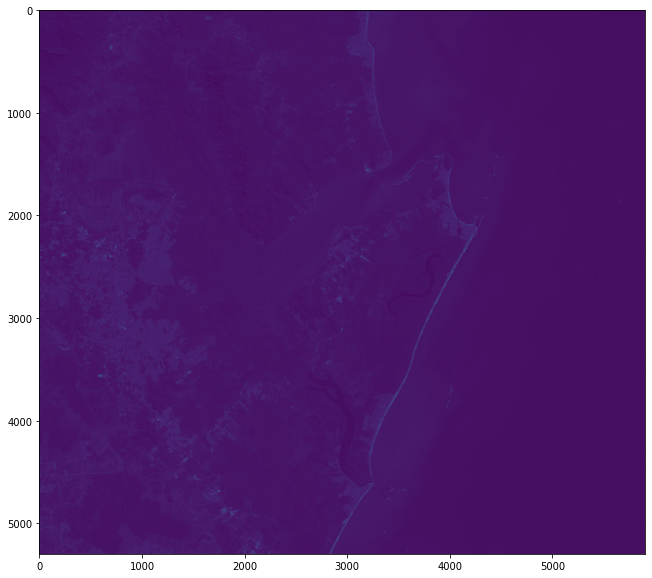

In [19]:
plt.figure(figsize=(12,10))
plt.imshow(tiff.asarray())

In [20]:
aux_dict = dict()
for page in tiff.pages:
    for tag in page.tags:
        aux_dict[tag.name] = tag.value

In [21]:
aux_dict['ModelTiepointTag']

(0.0, 0.0, 0.0, 707160.0, 7117780.0, 0.0)

## 1. Relacionar as imagens com as coordenadas (tags)
ModelTiepointTag = (...,I,J,K, X,Y,Z...)

where (I,J,K) is the point at location (I,J) in raster space with pixel-value K, and (X,Y,Z) is a vector in model space. In most cases the model space is only two-dimensional, in which case both K and Z should be set to zero; this third dimension is provided in anticipation of future support for 3D digital elevation models and vertical coordinate systems.

In [22]:
def get_coord_from_pixel_pos(i, j, start_value_x, start_value_y, scale_x, scale_y):
    """
    i : int - coord x 
    j : int - coord y
    start_value_x : int - start coord x UTM
    start_value_y : int - start coord y UTM
    scale_x : int - pixel/meter scale x
    scale_y : int - pixel/meter scale y
    """
    return (start_value_x+scale_x*i, start_value_y-scale_y*j)

def get_pixel_from_coord(coord_x,coord_y, scale_x, scale_y, start_x, start_y):
    return (int((coord_x-start_x)/scale_x), int((start_y-coord_y)/scale_y))

In [23]:
scale_x = aux_dict['ModelPixelScaleTag'][0]
scale_y = aux_dict['ModelPixelScaleTag'][1]
start_value_x = aux_dict['ModelTiepointTag'][3]
start_value_y = aux_dict['ModelTiepointTag'][4]

In [24]:
start_value_x, start_value_y

(707160.0, 7117780.0)

In [25]:
get_coord_from_pixel_pos(10, 20, start_value_x, start_value_y, scale_x, scale_y)

(707260.0, 7117580.0)

## 2. Acessar os dados da batimetria

In [26]:
path_bat = '/home/vinicius/Área de Trabalho/Faculdade/TCC/data/DADOS_TCC_BIANCA/02.Dados_Processados/02.XYZ/BATIMETRIA_PROCESSADA_BABITONGA_2018_DHN_WGS84_UTM22S.xyz'

In [27]:
df = pd.read_csv(path_bat, sep=' ', header=None)
df.columns = ['x', 'y', 'z']
df

,x,y,z
0,720507.82,7089857.17,1.96
1,720507.95,7089857.15,1.98
2,720508.07,7089857.12,1.98
3,720508.19,7089857.09,1.97
4,720508.31,7089857.07,1.98
...,...,...,...
557239,720868.85,7107250.49,3.41
557240,720868.95,7107250.55,3.41
557241,720869.05,7107250.60,3.41
557242,720869.14,7107250.65,3.41


Função para aplicar o algorítmo ndwi

In [28]:
def ndwi(first_band, second_band):
    if first_band.shape != second_band.shape:
        return None

    output = np.zeros(first_band.shape)

    for i in tqdm(range(first_band.shape[0])):
        for j in range(first_band.shape[1]):
            temp1 = first_band[i][j] - second_band[i][j]
            temp2 = first_band[i][j] + second_band[i][j]
            
            if temp2 == 0:
                output[i][j] = 1
                print("deu pau")
            else:
                temp3 = temp1/temp2
                output[i][j] = temp3
                
    return output

Função para gerar imagem com cores de acordo com a profundidade (em regiões com água)

In [ ]:
def bathymetry_mask(input_rgb, input_nwdi):
    output = np.copy(input_rgb)
    
    for i in range(input_rgb.shape[0]):
        for j in range(input_rgb.shape[1]):
            if input_nwdi[i][j] > 160:
                output[i][j] = [e*255 for e in (colorsys.hls_to_rgb(((input_nwdi[i][j])-130)*5.5/360, 0.5, 1))]
    return output

## 3.1 Filtro ndwi b5b3

In [31]:
path_b5 = Path('../data/DADOS_TCC_BIANCA/04.Imagens_de_Satelite/02.SR/S2A_MSI_2018_05_20_13_22_41_T22JGR_rhos_704.tif')

b3arr = tiff.asarray()
b5 = tifffile.TiffFile(path_b5)
b5arr = b5.asarray()

ndwib5b3 = ndwi(b5arr, b3arr)

In [37]:
jb.dump(ndwib5b3, 'output_data/ndwib5b3.pkl.z')

['output_data/ndwib5b3.pkl.z']

In [38]:
path_b8 = Path('../data/DADOS_TCC_BIANCA/04.Imagens_de_Satelite/02.SR/S2A_MSI_2018_05_20_13_22_41_T22JGR_rhos_833.tif')


b8 = tifffile.TiffFile(path_b8)
b8arr = b8.asarray()

## 3.2 Filtro ndwi b3b8

In [39]:
ndwib3b8 = ndwi(b3arr, b8arr)

In [40]:
jb.dump(ndwib3b8, 'output_data/ndwib3b8.pkl.z')

['output_data/ndwib3b8.pkl.z']

In [41]:
ndwib3b8.max(), ndwib3b8.min()

(1061.33984375, -12956.099609375)

### Separação do que é ou não água, com threshold de 0.3

In [42]:
binary = (ndwib3b8[:,:] > 0.3).astype(np.uint8)*255

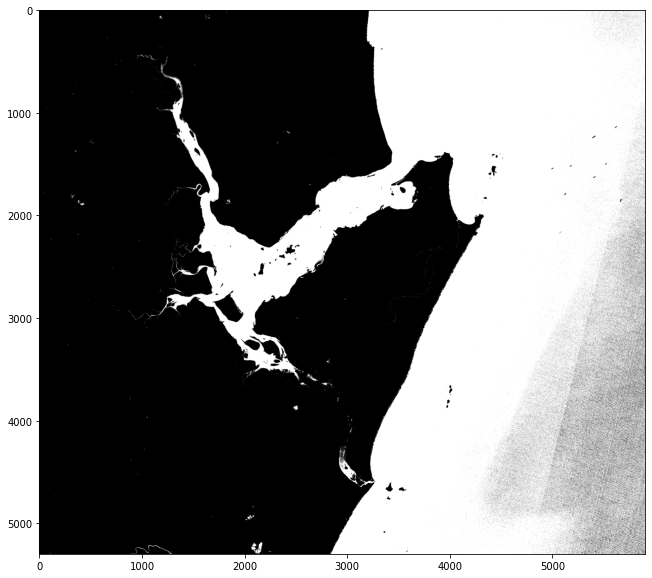

In [43]:
plt.figure(figsize=(12,10))
plt.imshow(binary, 'gray')

In [193]:
import cv2

In [195]:
cv2.imwrite("test.jpg", binary)

True

In [44]:
new_image = np.zeros(binary.shape)

Acessar todas as posições das coordenadas da batimetria na imagem e pintar de branco

In [45]:
for i, row in enumerate(df.itertuples()):
    x = row[1]
    y = row[2]
    z = row[3]
    pixel = get_pixel_from_coord(x, y, scale_x, scale_y, start_value_x, start_value_y)
    new_image[pixel[1]][pixel[0]] = 255

### Região da batimetria

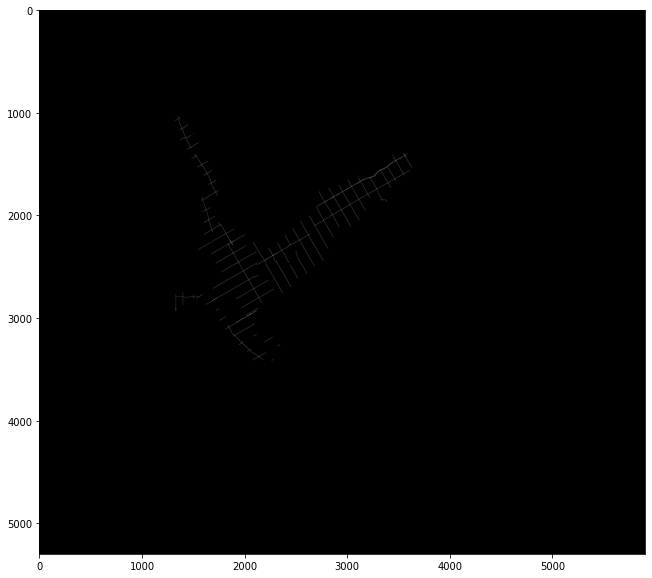

In [46]:
plt.figure(figsize=(12, 10))
plt.imshow(new_image,'gray')


In [246]:
cv2.imwrite('output.png', new_image)

True

In [47]:
df2 = df.copy()

Acessar todas as posições do resultado do filtro ndwi b5 b3 com valor de batimetria

In [50]:
aux = list()
for i, row in enumerate(df.itertuples()):
    x = row[1]
    y = row[2]
    z = row[3]
    pixel = get_pixel_from_coord(x, y, scale_x, scale_y, start_value_x, start_value_y)
    aux.append(ndwib5b3[pixel[1]][pixel[0]])
df2['reflectance'] = aux

## 4. Modelagem

In [81]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score

In [53]:
#rf = RandomForestRegressor(n_estimators=500)

### Feature = resultado do ndwi b5 b3
### Target = profundidade medida

In [54]:
features = df2['reflectance']
target = df2['z']

Separação do conjunto de dados para treinamento e para teste (50% para cada)

In [55]:
X_train, X_val, y_train, y_val = train_test_split(features, target, test_size=0.5)

In [64]:
X_train = np.array(X_train).reshape(-1, 1)
X_val = np.array(X_val).reshape(-1, 1)

In [57]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((278622, 1), (278622,), (278622,), (278622,))

In [59]:
X_val.max(), X_train.max()

(0.39804214239120483, 0.39804214239120483)

In [ ]:
#rf.fit(X_train, y_train)

In [69]:
#p = rf.predict(X_val)
# modelo de treinamento anterior, com r² levemente abaixo de 0.5

### Treinamento

In [87]:
lgbm = LGBMRegressor(n_estimators=500, )

In [88]:
lgbm.fit(X_train, y_train)

LGBMRegressor()

In [89]:
p = lgbm.predict(X_val)

### R² = 0.52

In [90]:
r2_score(y_val, p)

0.5210705391155394

In [94]:
space = [(1e-3, 1e-1, 'log-uniform'), # lr
          (1, 10), # max_depth
          (1, 20), # min_child_samples
          (0.05, 1.), # subsample
          (0.05, 1.), # colsample_bytree
          (100,1000)] # n_estimator


In [108]:
from skopt import forest_minimize

def tune_lgbm(args):
    lr = args[0]
    max_depth = args[1]
    min_child_samples = args[2]
    subsample = args[3]
    colsample_bytree = args[4]
    n_estimators = args[5]
    
    mdl = LGBMRegressor(learning_rate=lr, max_depth=max_depth, min_child_samples=min_child_samples, subsample=subsample, colsample_bytree=colsample_bytree, n_estimators=n_estimators)
    mdl.fit(X_train, y_train)
    p = mdl.predict(X_val)
    print(r2_score(y_val, p))
    
    return -r2_score(y_val, p)

In [109]:
res = forest_minimize(tune_lgbm, space, random_state=160000, n_random_starts=20, n_calls=50, verbose=0)

0.5181429655410597
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
0.520964619701052
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
0.5207760609076264
0.4471976480997445
0.5092847295282333
0.5206382862750173
0.511306924401464
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
0.5145800143159345
0.5139836796774373
0.519015143978783
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
0.184743028606853
0.518582548632902
0.5204411121033055
0.5198822873825169
0.5210602766124146
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
0.5130864920718738
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
0.521083180323969
0.5197448945170682
0.4537040259141867
[LightGBM] [Warning] Accuracy may

In [115]:
res['x']

[0.06051437961424099, 10, 14, 0.7701093805754321, 0.31952225508191234, 726]